In [1]:
import os

import pandas as pd
import numpy as np
import itertools
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib.ticker import MultipleLocator
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.transforms import ScaledTranslation

plt.rcParams['legend.handlelength'] = 1
plt.rcParams['legend.handleheight'] = 1.125
plt.rcParams["font.family"]         = "Avenir"

path_to_scenarios = '/Users/Guille/Desktop/india_power/scenarios'
path_to_images    = '/Users/Guille/Desktop/india_power/images'
path_to_csvs      = '/Users/Guille/Desktop/india_power/gridpath_india_viz/csvs'

In [2]:
# Grab data from databases for plotting new and existing capacity
def _load_capacity(scen_labels_):

    # Load project capacity table and process them from database
    def __load_new_and_existing_csv(df_, scenario):

        df_['capacity_mw'] = df_['capacity_mw'].astype(float)
        df_['status']      = 'new'
        df_                = df_[['project', 
                                  'period', 
                                  'technology', 
                                  'load_zone', 
                                  'status', 
                                  'capacity_mw', 
                                  'energy_capacity_mwh']]

        idx_  = (df_['period'] == 2020) & (df_['capacity_mw'] != 0.)
        df_.loc[capacity_['project'].isin(df_.loc[idx_, 'project'].unique()), 'status'] = 'existing'
        
        df_ = df_.groupby(['period', 
                           'technology', 
                           'load_zone',
                           'status']).agg({'capacity_mw': 'sum', 
                                           'energy_capacity_mwh': 'sum'})

        df_ = df_.reset_index(drop = False).rename(columns = {'energy_capacity_mwh': 'capacity_mwh'})

        df_['scenario'] = scenario

        return df_
    
    dfs_ = []
    # Open connection: open database and grab meta-data
    for scen, path in zip(scen_labels_['scenario'],  scen_labels_['path']):
        print(scen, path)
        dir_name  = r'{}/{}'.format(path, scen)
        capacity_ = pd.read_csv(dir_name + r'/results/project_period.csv', low_memory = False)
        df_       = __load_new_and_existing_csv(capacity_, scen)
        
        # Load specified capacity from csv files
        dfs_.append(df_)

    return pd.concat(dfs_, axis = 0).reset_index(drop = True)

# Grab data from databases for plotting energy dispatch and clean energy targets
def _load_dispatch(scen_labels_):

    # Load energy dispatch table and process data from database
    def __load_dispatch_from_csv(df_, scenario, zone):
        
        df_['power_mw'] = df_['number_of_hours_in_timepoint']*df_['timepoint_weight']*df_['power_mw']

        df_ = df_[['period', 'technology', 'load_zone', 'power_mw']]
            
        df_ = df_.groupby(['period', 
                           'technology', 
                           'load_zone']).agg({'power_mw': 'sum'}).reset_index(drop = False)
        
        df_['scenario'] = scenario
                
        return df_
        
    # Load energy dispatch table and process data from database
    def __load_demand_from_csv(df_, scenario, zone):
        
        df_['overgeneration_mw']  = df_['number_of_hours_in_timepoint']*df_['timepoint_weight']*df_['overgeneration_mw']
        df_['unserved_energy_mw'] = df_['number_of_hours_in_timepoint']*df_['timepoint_weight']*df_['unserved_energy_mw']
        
        df_1_               = df_[['period', 'load_zone', 'overgeneration_mw']].copy()
        df_1_['technology'] = 'Curtailment'                
        df_1_               = df_1_.rename(columns = {'overgeneration_mw': 'power_mw'})

        df_2_               = df_[['period', 'load_zone', 'unserved_energy_mw']].copy()
        df_2_['technology'] = 'Shedding'                 
        df_2_               = df_2_.rename(columns = {'unserved_energy_mw': 'power_mw'})

        df_ = pd.concat([df_1_, df_2_], axis = 0)
            
        df_ = df_.groupby(['period', 
                           'technology', 
                           'load_zone']).agg({'power_mw': 'sum'}).reset_index(drop = False)
        
        df_['scenario'] = scenario
                                  
        return df_

    def __load_tx_losses_from_csv(df_, scenario, zone):
        
        df_['transmission_losses_lz_to']   = - df_['number_of_hours_in_timepoint']*df_['timepoint_weight']*df_['transmission_losses_lz_to'] 
        df_['transmission_losses_lz_from'] = - df_['number_of_hours_in_timepoint']*df_['timepoint_weight']*df_['transmission_losses_lz_from']

        df_1_               = df_[['period', 'load_zone_to', 'transmission_losses_lz_to']].copy()
        df_1_['technology'] = 'Transmission Losses'
        df_1_               = df_1_.rename(columns = {'transmission_losses_lz_to': 'power_mw', 
                                                      'load_zone_to': 'load_zone'})

        df_2_               = df_[['period', 'load_zone_from', 'transmission_losses_lz_from']].copy()
        df_2_['technology'] = 'Transmission Losses'
        df_2_               = df_2_.rename(columns = {'transmission_losses_lz_from': 'power_mw',
                                                      'load_zone_from': 'load_zone'})
        
        df_ = pd.concat([df_1_, df_2_], axis = 0)
        
        df_ = df_.groupby(['period', 
                           'technology', 
                           'load_zone']).agg({'power_mw': 'sum'}).reset_index(drop = False)

        df_['scenario'] = scenario
        
        return df_

    dfs_ = []
    # Open connection: open database and grab meta-data
    for scenario, zone, path in zip(scen_labels_['scenario'], scen_labels_['zone'], scen_labels_['path']):
        print(scenario, zone, path)
        
        dir_name   = r'{}/{}'.format(path, scenario)
        dispatch_  = pd.read_csv(dir_name + f'/results/project_timepoint.csv', low_memory = False)
        demand_    = pd.read_csv(dir_name + f'/results/system_load_zone_timepoint.csv', low_memory = False)
        tx_losses_ = pd.read_csv(dir_name + f'/results/transmission_timepoint.csv', low_memory = False)
        
        dfs_ += [__load_tx_losses_from_csv(tx_losses_, scenario, zone)]
        dfs_ += [__load_demand_from_csv(demand_, scenario, zone)]
        dfs_ += [__load_dispatch_from_csv(dispatch_, scenario, zone)]

    return pd.concat(dfs_, axis = 0).reset_index(drop = True)


# Grab data from databases for plotting new and existing capacity
def _load_new_build_capacity(scen_labels_):

    # Load project capacity table and process them from database
    def __load_pipeline_and_existing_csv(df_, scenario):

        df_ = df_[['project', 
                   'period', 
                   'technology', 
                   'load_zone', 
                   'capacity_mw',
                   'energy_capacity_mwh',
                   'new_build_mw', 
                   'new_build_mwh']]
        
        df_p_ = df_.copy()

        df_p_['status']                                                 = 'existing'
        df_p_.loc[df_p_['project'].str.contains('_pipeline'), 'status'] = 'pipeline'
        df_p_.loc[df_p_['project'].str.contains('_new'), 'status']      = 'new'
        df_p_.loc[df_p_['project'].str.contains('2029'), 'status']      = 'pipeline'
        
        idx_ = (df_p_['status'] == 'pipeline') | (df_p_['status'] == 'existing')
        for project in df_p_.loc[idx_, 'project']:
            
            df_p_.loc[df_p_['project'] == project, 'new_build_mw']  = df_p_.loc[df_p_['project'] == project, 'capacity_mw'].diff().fillna(0) 
            df_p_.loc[df_p_['project'] == project, 'new_build_mwh'] = df_p_.loc[df_p_['project'] == project, 'energy_capacity_mwh'].diff().fillna(0) 
        
        df_p_.loc[df_p_['status'] == 'pipeline', 'status'] = 'new'
        
        df_p_ = df_p_.groupby(['period', 
                               'technology', 
                               'load_zone',
                               'status']).agg({'new_build_mw': 'sum', 
                                               'new_build_mwh': 'sum'}).reset_index(drop = False)

        
        df_p_ = df_p_[['period', 
                       'technology', 
                       'load_zone', 
                       'status',
                       'new_build_mw', 
                       'new_build_mwh']]
        
        df_p_ = df_p_.rename(columns = {'new_build_mw': 'capacity_mw',
                                        'new_build_mwh': 'capacity_mwh'})

        df_p_['scenario'] = scenario

        return df_p_
    
    dfs_ = []
    # Open connection: open database and grab meta-data
    for scen, path in zip(scen_labels_['scenario'],  scen_labels_['path']):
        print(scen, path)
        dir_name  = r'{}/{}'.format(path, scen)
        capacity_ = pd.read_csv(dir_name + r'/results/project_period.csv', low_memory = False)
        df_       = __load_pipeline_and_existing_csv(capacity_, scen)
        
        # Load specified capacity from csv files
        dfs_.append(df_)

    return pd.concat(dfs_, axis = 0).reset_index(drop = True)

In [3]:
def _group_by_zone(df_, scen_labels_, columns_ = ['period', 
                                                  'technology', 
                                                  'scenario', 
                                                  'load_zone', 
                                                  'status']):
    
    dfs_ = []
    # Open connection: open database and grab meta-data
    for scen, zone in zip(scen_labels_['scenario'], scen_labels_['zone']):
        
        df_p_ = df_.loc[df_['scenario'] == scen].copy()
        
        idx_ = df_p_['load_zone'] == zone
        
        if idx_.sum() == 0.:
            df_p_['load_zone'] = 'all'
        else:
            df_p_ = df_p_.loc[idx_].reset_index(drop = True)
        
        dfs_.append(df_p_.groupby(columns_).sum().reset_index(drop = False))
        
    df_                 = pd.concat(dfs_, axis = 0).reset_index(drop = True)
    df_['period']       = df_['period'].astype(int)
    df_['capacity_mw']  = df_['capacity_mw'].astype(float)
    df_['capacity_mwh'] = df_['capacity_mwh'].astype(float)

    return df_

def _group_capacity_technologies(capacity_, tech_labels_):

    for group in tech_labels_['group'].unique():
        capacity_.loc[capacity_['technology'].isin(tech_labels_.loc[tech_labels_['group'] == group, 'technology']), 'technology'] = group
        
    capacity_ = capacity_.groupby(['period', 
                                   'technology', 
                                   'load_zone', 
                                   'status', 
                                   'scenario']).agg({'capacity_mw': 'sum', 
                                                     'capacity_mwh': 'sum'})

    return capacity_.reset_index(drop = False)

def _group_dispatch_technologies(df_, tech_labels_):

    for group in tech_labels_['group'].unique():
        df_.loc[df_['technology'].isin(tech_labels_.loc[tech_labels_['group'] == group, 'technology']), 'technology'] = group
        
    df_ = df_.groupby(['period', 
                       'technology', 
                       'load_zone', 
                       'scenario']).agg({'power_mw': 'sum'})

    return df_.reset_index(drop = False)

In [4]:
def _plot_new_and_existing_capacity(ax, df_, scens_label_, tech_label_, 
                                    y_lim_max    = None,
                                    units        = 1e3,
                                    ylabel       = 'Existing & New Capacity (GW)',
                                    y_period_loc = -1600.,
                                    y_grid_inc   = 500,
                                    div_line_len = 0.325,
                                    legend       = True,
                                    title        = ''):

    y_period_loc = y_period_loc*y_lim_max

    def __make_new_and_existing_capacit_legend(ax, df_, techs_):

        tech_idx_ = np.sort(np.unique(techs_['order']))

        ax.bar(0., 0., 0., bottom    = 0.,
                           label     = 'Existing',
                           color     = 'None',
                           lw        = 0.,
                           hatch     = 'xx',
                           edgecolor = 'lightgray',
                           zorder    = 10)

        for i_tech in tech_idx_[::-1]:
            tech  = tech_label_.loc[tech_label_['order'] == i_tech, 'group'].unique()[0]
            color = tech_label_.loc[tech_label_['order'] == i_tech, 'group_color'].unique()[0]
            idx_  = df_['technology'] == tech
            if idx_.sum() > 0:
                if df_.loc[idx_, 'capacity_mw'].sum() != 0:
                    ax.bar(0., 0., 0., bottom = 0.,
                                       color  = color,
                                       label  = tech,
                                       zorder = 10)

    periods_  = np.sort(df_['period'].unique())
    scens_    = scens_label_['scenario'].unique()    
    tech_idx_ = np.sort(np.unique(tech_label_['order']))

    ticks_    = []
    labels_   = []
    offsets_  = []
    lengths_  = []
    x_period_ = []
    
    i_scen = 0
    offset = 0
    y_max  = 0
    
    width  = 1/(len(scens_) + 1.5)
    x_     = np.linspace(0, len(periods_) - 1, len(periods_))
    
    for scen, label, zone in zip(scens_label_['scenario'], scens_label_['label'], scens_label_['zone']):

        df_p_ = df_.copy()
        
        if (df_p_['load_zone'] == zone).sum() == 0.:
            df_p_['load_zone'] = zone
            df_p_ = df_p_.groupby(['period', 
                                   'technology', 
                                   'load_zone', 
                                   'status',
                                   'scenario']).agg({'capacity_mw': 'sum'}).reset_index(drop = False)
            
        idx_ = (df_p_['scenario'] == scen) & (df_p_['load_zone'] == zone)
                
        for period, i_period in zip(periods_, range(len(periods_))):
            idx_1_ = idx_ & (df_p_['period'] == period)
            if (i_scen == 0) & (i_period == 0): 
                __make_new_and_existing_capacit_legend(ax, df_p_, tech_label_)

            for i_tech in tech_idx_:
                
                tech  = tech_label_.loc[tech_label_['order'] == i_tech, 'group'].unique()[0]
                color = tech_label_.loc[tech_label_['order'] == i_tech, 'group_color'].unique()[0]
                
                idx_2_ = idx_1_ & (df_p_['status'] == 'existing') & (df_p_['technology'] == tech)

                if idx_2_.sum() == 1.:
                    power = df_p_.loc[idx_2_, 'capacity_mw'].to_numpy()[0]

                    ax.bar(x_[i_period], power/units, width, bottom    = offset/units,
                                                             color     = color,
                                                             lw        = 0.,
                                                             hatch     = 'x',
                                                             edgecolor = 'lightgray', zorder = 10)

                    offset += power

            for i_tech in tech_idx_:
                
                tech  = tech_label_.loc[tech_label_['order'] == i_tech, 'group'].unique()[0]
                color = tech_label_.loc[tech_label_['order'] == i_tech, 'group_color'].unique()[0]
                
                idx_3_ = idx_1_ & (df_p_['technology'] == tech) & (df_p_['status'] == 'new')
                if idx_3_.sum() == 1.:
                    power = df_p_.loc[idx_3_, 'capacity_mw'].to_numpy()[0]

                    ax.bar(x_[i_period], power/units, width, bottom = offset/units,
                                                             color  = color,
                                                             zorder = 10)

                    offset += power

            if y_max < offset:
                y_max = offset

            ticks_.append(x_[i_period])
            labels_.append(label)
            offsets_.append(offset/units)
            x_period_.append(x_[i_period])

            offset = 0.

        x_ = x_ + .9/len(scens_)
        i_scen += 1
        
    z_ = x_ - .9/len(scens_)

    x_period_ = np.mean(np.array(x_period_).reshape(len(scens_), len(periods_)), axis = 0)
    y_period_ = np.max(np.array(offsets_).reshape(len(scens_), len(periods_)), axis = 0)
    
#     for x_period, y_period, period in zip(x_period_, y_period_, periods_):
#         ax.text(x_period, y_period_loc, period, fontsize            = 18, 
#                                                  weight              = 'bold',
#                                                  horizontalalignment = 'center', 
#                                                  verticalalignment   = 'center')

#     x_ = np.linspace(0, len(periods_), len(periods_) + 1)
#     dz = (x_[1] - z_[0])
#     for x in x_:
#         ax.axvline(x - dz/2., ymin      = 0.,
#                               ymax      = - div_line_len,
#                               linewidth = .75,
#                               linestyle = '-',
#                               color     = 'k',
#                               clip_on   = False,
#                               zorder    = 10)

    ax.set_ylabel(ylabel, fontsize = 18)

    if legend:
        ax.legend(loc            = 'center left',
                  bbox_to_anchor = (1, 0.5),
                  frameon        = False,
                  prop           = {'size': 15})

    if y_lim_max != None:
        ax.set_ylim(0., y_lim_max)
        y_max = y_lim_max
    else:
        ax.set_ylim(0., y_period_.max()*1.2)
        y_max /= units
        
    N_steps  = int(np.ceil(y_max/y_grid_inc))
    y_ticks_ = np.linspace(0, int(N_steps*y_grid_inc), N_steps + 1, dtype = int)
    
    ax.set_yticks(y_ticks_, y_ticks_)
    #ax.set_xticks(ticks_, labels_, rotation = 90)
    ax.set_xticks(x_period_, periods_)

    ax.xaxis.set_tick_params(labelsize = 19, 
                             left      = False)
    
    ax.yaxis.set_tick_params(labelsize = 15, 
                             left      = False)
    
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    ax.axhline(0, linewidth = .5, 
                  linestyle = '-', 
                  color     = 'k', 
                  clip_on   = False, 
                  zorder    = 10)
    
    ax.set_title(title, fontsize = 20, y = 0.912)

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    ax.grid(axis = 'y')
    
    
def _plot_new_and_existing_storage(ax, df_, scens_label_, tech_label_, 
                                   units        = 1e3,
                                   ylabel       = 'Existing & New Capacity (GW)',
                                   y_period_loc = -6250.,
                                   y_grid_inc   = 2000,
                                   div_line_len = 0.325,
                                   y_lim_max    = None,
                                   legend       = True,
                                   title        = ''):

    y_period_loc = y_period_loc*y_lim_max

    def __make_new_and_existing_capacit_legend(ax, df_, techs_):
        
        tech_idx_ = np.sort(np.unique(techs_['order']))

        ax.bar(0., 0., 0., bottom    = 0.,
                           label     = 'Existing',
                           color     = 'None',
                           lw        = 0.,
                           hatch     = 'xx',
                           edgecolor = 'lightgray',
                           zorder    = 10)
            
        for i_tech in tech_idx_[::-1]:
            tech  = tech_label_.loc[tech_label_['order'] == i_tech, 'group'].unique()[0]
            color = tech_label_.loc[tech_label_['order'] == i_tech, 'group_color'].unique()[0]
            
            idx_ = df_['technology'] == tech
            if idx_.sum() > 0:
                if df_.loc[idx_, 'capacity_mwh'].sum() != 0:
                    ax.bar(0., 0., 0., bottom = 0.,
                                       color  = color,
                                       label  = tech,
                                       zorder = 10)

    periods_  = np.sort(df_['period'].unique())
    scens_    = scens_label_['scenario'].unique()    
    tech_idx_ = np.sort(np.unique(tech_label_['order']))

    ticks_    = []
    labels_   = []
    offsets_  = []
    lengths_  = []
    x_period_ = []
    
    i_scen = 0
    offset = 0
    y_max  = 0
    
    width  = 1/(len(scens_) + 1.5)
    x_     = np.linspace(0, len(periods_) - 1, len(periods_))
    
    for scen, label, zone in zip(scens_label_['scenario'], scens_label_['label'], scens_label_['zone']):

        df_p_ = df_.copy()
        
        if (df_p_['load_zone'] == zone).sum() == 0.:
            df_p_['load_zone'] = zone
            df_p_ = df_p_.groupby(['period', 
                                   'technology', 
                                   'load_zone', 
                                   'status',
                                   'scenario']).agg({'capacity_mwh': 'sum'}).reset_index(drop = False)
            
        idx_ = (df_p_['scenario'] == scen) & (df_p_['load_zone'] == zone)
                
        for period, i_period in zip(periods_, range(len(periods_))):
            idx_1_ = idx_ & (df_p_['period'] == period)
            if (i_scen == 0) & (i_period == 0): 
                __make_new_and_existing_capacit_legend(ax, df_p_, tech_label_)
                
            for i_tech in tech_idx_:
                
                tech  = tech_label_.loc[tech_label_['order'] == i_tech, 'group'].unique()[0]
                color = tech_label_.loc[tech_label_['order'] == i_tech, 'group_color'].unique()[0]
                
                idx_2_ = idx_1_ & (df_p_['status'] == 'existing') & (df_p_['technology'] == tech)

                if idx_2_.sum() == 1.:
                    power = df_p_.loc[idx_2_, 'capacity_mwh'].to_numpy()[0]

                    ax.bar(x_[i_period], power/units, width, bottom    = offset/units,
                                                             color     = color,
                                                             lw        = 0.,
                                                             hatch     = 'x',
                                                             edgecolor = 'lightgray', zorder = 10)

                    offset += power

            for i_tech in tech_idx_:
                
                tech  = tech_label_.loc[tech_label_['order'] == i_tech, 'group'].unique()[0]
                color = tech_label_.loc[tech_label_['order'] == i_tech, 'group_color'].unique()[0]
                
                idx_3_ = idx_1_ & (df_p_['technology'] == tech) & (df_p_['status'] == 'new')
                
                if idx_3_.sum() == 1.:
                    power = df_p_.loc[idx_3_, 'capacity_mwh'].to_numpy()[0]

                    ax.bar(x_[i_period], power/units, width, bottom = offset/units,
                                                             color  = color,
                                                             zorder = 10)

                    offset += power

            if y_max < offset:
                y_max = offset

            ticks_.append(x_[i_period])
            labels_.append(label)
            offsets_.append(offset/units)
            x_period_.append(x_[i_period])

            offset = 0.

        x_ = x_ + .9/len(scens_)
        i_scen += 1
        
    z_ = x_ - .9/len(scens_)

    x_period_ = np.mean(np.array(x_period_).reshape(len(scens_), len(periods_)), axis = 0)
    y_period_ = np.max(np.array(offsets_).reshape(len(scens_), len(periods_)), axis = 0)
    
    # for x_period, y_period, period in zip(x_period_, y_period_, periods_):
    #     ax.text(x_period, y_period_loc, period, fontsize            = 18, 
    #                                              weight              = 'bold',
    #                                              horizontalalignment = 'center', 
    #                                              verticalalignment   = 'center')

    # x_ = np.linspace(0, len(periods_), len(periods_) + 1)
    # dz = (x_[1] - z_[0])
    # for x in x_:
    #     ax.axvline(x - dz/2., ymin      = 0.,
    #                           ymax      = - div_line_len,
    #                           linewidth = .75,
    #                           linestyle = '-',
    #                           color     = 'k',
    #                           clip_on   = False,
    #                           zorder    = 10)

    ax.set_ylabel(ylabel, fontsize = 18)


    if legend:
        ax.legend(loc            = 'center left',
                  bbox_to_anchor = (1, 0.5),
                  frameon        = False,
                  prop           = {'size': 15})

    if y_lim_max != None:
        ax.set_ylim(0., y_lim_max)
        y_max = y_lim_max
    else:
        ax.set_ylim(0., )
        y_max /= units
        
    N_steps  = int(np.ceil(y_max/y_grid_inc))
    y_ticks_ = np.linspace(0, int(N_steps*y_grid_inc), N_steps + 1, dtype = int)
    ax.set_yticks(y_ticks_, y_ticks_)
    #ax.set_xticks(ticks_, labels_, rotation = 90)
    ax.set_xticks(x_period_, periods_)
    
    ax.xaxis.set_tick_params(labelsize = 19, 
                             left      = False)
    
    ax.yaxis.set_tick_params(labelsize = 15, 
                             left      = False)

    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    ax.set_title(title, fontsize = 20, y = 0.912)
    
    ax.axhline(0, linewidth = .5, 
                  linestyle = '-', 
                  color     = 'k', 
                  clip_on   = False, 
                  zorder    = 10)

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    ax.grid(axis = 'y')

def _plot_dispatch(ax, df_, scens_label_, tech_label_, 
                   y_lim_max    = None,
                   y_lim_min    = None,
                   units        = 1e6,
                   ylabel       = r'Electricity Generation (TWh)',
                   y_period_loc = -3870.,
                   y_grid_inc   = 1000,
                   div_line_len = .425,
                   legend       = True,
                   title        = ''):
    
    y_period_loc = y_period_loc*(y_lim_max - y_lim_min)

    def __make_dispatch_legend(ax, df_, techs_):

        tech_idx_ = np.sort(np.unique(techs_['order_v2']))

        ax.bar(0., 0., 0., bottom    = 0.,
                           label     = 'Existing',
                           color     = 'None',
                           lw        = 0.,
                           hatch     = 'xx',
                           edgecolor = 'lightgray',
                           zorder    = 10)
        
        for i_tech in tech_idx_[::-1]:
            tech  = tech_label_.loc[tech_label_['order_v2'] == i_tech, 'group'].unique()[0]
            color = tech_label_.loc[tech_label_['order_v2'] == i_tech, 'group_color'].unique()[0]
            
            idx_ = df_['technology'] == tech
            if idx_.sum() > 0:
                if df_.loc[idx_, 'power_mw'].to_numpy().sum() != 0:
                    ax.bar(0., 0., 0., bottom = 0.,
                                       color  = color,
                                       label  = tech.replace('_', ' '),
                                       zorder = 2,
                                       ec     = 'None',
                                       lw     = 0.,
                                       aa     = True)

    periods_  = np.sort(df_['period'].unique())
    scens_    = scens_label_['scenario'].unique()    
    tech_idx_ = np.sort(np.unique(tech_label_['order']))

    width = 1./(len(scens_) + 1.5)
    x_    = np.linspace(0, len(periods_) - 1, len(periods_))

    ticks_    = []
    labels_   = []
    x_period_ = []
    y_period_ = []
    
    i_scen          = 0
    offset_positive = 0.
    offset_negative = 0.    
    y_max           = 0
    y_min           = 0
    
    for scen, label, zone in zip(scens_label_['scenario'], scens_label_['label'], scens_label_['zone']):
        df_p_ = df_.copy()
        
        if (df_p_['load_zone'] == zone).sum() == 0.:
            df_p_['load_zone'] = zone
            df_p_ = df_p_.groupby(['period', 
                                   'technology', 
                                   'load_zone', 
                                   'scenario']).agg({'power_mw': 'sum'}).reset_index(drop = False)
            
        idx_ = (df_p_['scenario'] == scen) & (df_p_['load_zone'] == zone)

        for period, i_period in zip(periods_, range(len(periods_))):
            idx_1_ = idx_ & (df_p_['period'] == period)
            
            if (i_scen == 0) & (i_period == 0): 
                __make_dispatch_legend(ax, df_p_, tech_label_)

            for i_tech in tech_idx_:
                
                tech  = tech_label_.loc[tech_label_['order'] == i_tech, 'group'].unique()[0]
                color = tech_label_.loc[tech_label_['order'] == i_tech, 'group_color'].unique()[0]
                
                idx_2_ = idx_1_ & (df_p_['technology'] == tech)

                if idx_2_.sum() == 1:
                    power = float(df_p_.loc[idx_2_, 'power_mw'].to_numpy()[0])

                    if power != 0:
                        if power > 0:
                            offset = offset_positive
                        else:
                            offset = offset_negative

                        ax.bar(x_[i_period], power/units, width, bottom = offset/units,
                                                                 color  = color,
                                                                 zorder = 2,
                                                                 ec     = 'None',
                                                                 lw     = 0.,
                                                                 aa     = True)

                        if power >= 0:
                            offset_positive += power
                        else:
                            offset_negative += power

            if offset_negative/units < y_min: 
                y_min = offset_negative/units
            if offset_positive/units > y_max: 
                y_max = offset_positive/units

            ticks_.append(x_[i_period])
            labels_.append(label)
            x_period_.append(x_[i_period])
            y_period_.append(offset_positive)
            
            offset_positive = 0.
            offset_negative = 0.

        x_ = x_ + .9/len(scens_)
        
        i_scen += 1
        
    z_ = x_ - .9/len(scens_)

    x_period_ = np.mean(np.array(x_period_).reshape(len(scens_), len(periods_)), axis = 0)
    y_period_ = np.max(np.array(y_period_).reshape(len(scens_), len(periods_)), axis = 0)

    # for x_period, y_period, period in zip(x_period_, y_period_, periods_):
    #     ax.text(x_period, y_period_loc, period, fontsize            = 18, 
    #                                              weight              = 'bold',
    #                                              horizontalalignment = 'center', 
    #                                              verticalalignment   = 'center')

    ax.set_ylabel(ylabel, fontsize = 18)

    # x_ = np.linspace(0, len(periods_), len(periods_) + 1)
    # dz = (x_[1] - z_[0])
    # for x in x_:
    #     ax.axvline(x - dz/2., ymin      = 0.,
    #                           ymax      = -div_line_len,
    #                           linewidth = .75,
    #                           linestyle = '-',
    #                           color     = 'k',
    #                           clip_on   = False,
    #                           zorder    = 10)
        
    ax.axhline(0, linewidth = .5, 
                  linestyle = '-', 
                  color     = 'k', 
                  clip_on   = False, 
                  zorder    = 10)
    
    if legend:
        ax.legend(loc            = 'center left',
                  bbox_to_anchor = (1.025, 0.6),
                  frameon        = False,
                  prop           = {'size': 15})

    if (y_lim_min != None) & (y_lim_max != None):
        ax.set_ylim(y_lim_min, y_lim_max)
        y_max = y_lim_max
        
    N_steps  = int(np.ceil(y_max/y_grid_inc))
    y_ticks_ = np.linspace(0, int(N_steps*y_grid_inc), N_steps + 1, dtype = int)
    ax.set_yticks(y_ticks_, y_ticks_)
    
    #ax.set_xticks(ticks_, labels_, rotation = 90)
    ax.set_xticks(x_period_, periods_)

    ax.xaxis.set_tick_params(labelsize = 19, left = False)
    ax.yaxis.set_tick_params(labelsize = 15, left = False)

    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    ax.set_title(title, fontsize = 18, y = 0.9125)

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    ax.grid(axis = 'y')
    
def _plot_new_build_capacity(ax, df_, scens_label_, tech_label_, 
                             units        = 1e3,
                             ylabel       = 'New Build Capacity (GW)',
                             y_period_loc = -1800.,
                             y_grid_inc   = 500,
                             div_line_len = 0.5,
                             legend       = True,
                             title        = ''):

    def __make_new_build_capacity_legend(df_, techs_, colors_, ax):

        ax.bar(0., 0., 0., bottom    = 0.,
                           label     = 'Retirements',
                           color     = 'None',
                           lw        = 0.,
                           hatch     = 'xx',
                           edgecolor = 'lightgray',
                           zorder    = 10)

        for tech, i_tech in zip(techs_, range(len(techs_))):
            idx_ = df_['technology'] == tech
            if idx_.sum() > 0:
                if df_.loc[idx_, 'capacity_mw'].sum() != 0:
                    ax.bar(0., 0., 0., bottom = 0.,
                                       color  = colors_[i_tech],
                                       label  = tech,
                                       zorder = 10)

    periods_     = np.sort(df_['period'].unique())[1:]
    scens_       = scens_label_['scenario'].unique()    
    techs_, idx_ = np.unique(tech_label_['group'], return_index = True)
    colors_      = tech_label_.loc[tech_label_.index[idx_], 'group_color'].to_list()

    ticks_    = []
    labels_   = []
    offsets_  = []
    lengths_  = []
    x_period_ = []
    
    i_scen = 0
    
    width  = 1/(len(scens_) + 1)
    x_     = np.linspace(0, len(periods_) - 1, len(periods_))
    
    for scen, label, zone in zip(scens_label_['scenario'], 
                                 scens_label_['label'], 
                                 scens_label_['zone']):

        df_p_ = df_.copy()

        idx_ = (df_p_['scenario'] == scen) & (df_p_['load_zone'] == zone)
                
        for period, i_period in zip(periods_, range(len(periods_))):
            idx_1_ = idx_ & (df_p_['period'] == period)
            if (i_scen == 0) & (i_period == 0): 
                __make_new_build_capacity_legend(df_p_, techs_, colors_, ax)

            offset = 0.
            for tech, i_tech in zip(techs_, range(len(techs_))):
                idx_2_ = idx_1_ & (df_p_['technology'] == tech) & (df_p_['status'] == 'existing')

                if idx_2_.sum() == 1.:
                    power = df_p_.loc[idx_2_, 'capacity_mw'].to_numpy()[0]
                    color = tech_label_.loc[tech_label_['group'] == tech, 'group_color'].unique()

                    ax.bar(x_[i_period], power/units, width, bottom    = offset/units,
                                                             color     = color,
                                                             lw        = 0.,
                                                             hatch     = 'x',
                                                             edgecolor = 'lightgray',
                                                             zorder    = 10)

                    offset += power

            offset = 0
            for tech, i_tech in zip(techs_, range(len(techs_))):
                idx_3_ = idx_1_ & (df_p_['technology'] == tech) & (df_p_['status'] == 'new')
                if idx_3_.sum() == 1.:
                    power = df_p_.loc[idx_3_, 'capacity_mw'].to_numpy()[0]
                    color = tech_label_.loc[tech_label_['group'] == tech, 'group_color'].unique()

                    ax.bar(x_[i_period], power/units, width, bottom = offset/units,
                                                             color  = color,
                                                             zorder = 10)

                    offset += power

            ticks_.append(x_[i_period])
            labels_.append(label)
            offsets_.append(offset/units)
            x_period_.append(x_[i_period])

        x_ = x_ + .9/len(scens_)
        i_scen += 1
        
    z_ = x_ - .9/len(scens_)

    x_period_ = np.mean(np.array(x_period_).reshape(len(scens_), len(periods_)), axis = 0)
    y_period_ = np.max(np.array(offsets_).reshape(len(scens_), len(periods_)), axis = 0)
    
    # for x_period, y_period, period in zip(x_period_, y_period_, periods_):
    #     ax.text(x_period, y_period_loc, period, fontsize            = 18, 
    #                                              weight              = 'bold',
    #                                              horizontalalignment = 'center', 
    #                                              verticalalignment   = 'center')

    # x_ = np.linspace(0, len(periods_), len(periods_) + 1)
    # dz = (x_[1] - z_[0])
    # for x in x_:
    #     ax.axvline(x - dz/2., ymin      = 0.,
    #                           ymax      = - div_line_len,
    #                           linewidth = .75,
    #                           linestyle = '-',
    #                           color     = 'k',
    #                           clip_on   = False,
    #                           zorder    = 10)

    # N_steps  = int(np.ceil((y_max/units)/y_grid_inc))
    # y_ticks_ = np.linspace(0, int(N_steps*y_grid_inc), N_steps + 1, dtype = int)
    #ax.set_yticks(y_ticks_, y_ticks_)
    
    ax.set_xticks(x_period_, periods_)

    ax.axhline(0, linewidth = .5, 
                  linestyle = '-', 
                  color     = 'k', 
                  clip_on   = False, 
                  zorder    = 10)
    
    ax.set_ylabel(ylabel, fontsize = 18)
    

    ax.xaxis.set_tick_params(labelsize = 18, 
                             left      = False)
    
    ax.yaxis.set_tick_params(labelsize = 14, 
                             left      = False)

    # if legend:
    #     ax.legend(loc            = 'center left',
    #               bbox_to_anchor = (1, 0.5),
    #               frameon        = False,
    #               prop           = {'size': 14})

    #ax.set_ylim(-.75, y_period_.max()*1.2)
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    ax.set_title(title, fontsize = 20, y = 0.912)

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    ax.grid(axis = 'y')

In [5]:
tech_labels_ = pd.read_csv(path_to_csvs + '/technology_labels.csv') 

# Main Figure

Coal, Gas, Diesel, Nuclear, Other, Hydro, Solar, Wind, Pumped Storage, Battery, Hydrogen, Transmission Losses. The legend should also read in the same order, although the order doesn’t match the TWh plot because we represent only losses for storage and Tx. And Existing X on top.
Expand Tx to Transmission.


In [6]:
# Grab data from databases for plotting new and existing capacity
def _load_capacity_retirements(scen_labels_):

    # Load project capacity table and process them from database
    def __load_pipeline_and_existing_csv(df_, scenario):

        df_ = df_[['project', 
                   'period', 
                   'technology', 
                   'load_zone', 
                   'capacity_mw', 
                   'energy_capacity_mwh']]

        df_  = df_.loc[~df_['project'].isin(['_new'])].reset_index(drop = True)
        
        df_['status'] = 'existing'
        
        df_.loc[df_['project'].str.contains('_pipeline'), 'status'] = 'pipeline'
        df_.loc[df_['project'].str.contains('_new'), 'status'] = 'new'
        df_.loc[df_['project'].str.contains('2029'), 'status'] = 'pipeline'

        df_ = df_.groupby(['period', 
                           'technology', 
                           'load_zone',
                           'status']).agg({'capacity_mw': 'sum', 
                                           'energy_capacity_mwh': 'sum'})

        df_ = df_.reset_index(drop = False).rename(columns = {'energy_capacity_mwh': 'capacity_mwh'})

        df_['scenario'] = scenario

        return df_
    
    dfs_ = []
    # Open connection: open database and grab meta-data
    for scen, path in zip(scen_labels_['scenario'],  scen_labels_['path']):
        print(scen, path)
        dir_name  = r'{}/{}'.format(path, scen)
        capacity_ = pd.read_csv(dir_name + r'/results/project_period.csv', low_memory = False)
        df_       = __load_pipeline_and_existing_csv(capacity_, scen)
        
        # Load specified capacity from csv files
        dfs_.append(df_)

    return pd.concat(dfs_, axis = 0).reset_index(drop = True)


def _group_capacity_technologies(capacity_, tech_labels_):

    for group in tech_labels_['group'].unique():
        capacity_.loc[capacity_['technology'].isin(tech_labels_.loc[tech_labels_['group'] == group, 'technology']), 'technology'] = group
        
    capacity_ = capacity_.groupby(['period', 
                                   'technology', 
                                   'load_zone', 
                                   'status', 
                                   'scenario']).agg({'capacity_mw': 'sum', 
                                                     'capacity_mwh': 'sum'})

    return capacity_.reset_index(drop = False)

def _group_by_zone(df_, scen_labels_, columns_ = ['period', 
                                                  'technology', 
                                                  'scenario', 
                                                  'load_zone', 
                                                  'status']):
    
    dfs_ = []
    # Open connection: open database and grab meta-data
    for scen, zone in zip(scen_labels_['scenario'], scen_labels_['zone']):
        
        df_p_ = df_.loc[df_['scenario'] == scen].copy()
        
        idx_ = df_p_['load_zone'] == zone
        
        if idx_.sum() == 0.:
            df_p_['load_zone'] = 'all'
        else:
            df_p_ = df_p_.loc[idx_].reset_index(drop = True)
        
        dfs_.append(df_p_.groupby(columns_).sum().reset_index(drop = False))
        
    df_                 = pd.concat(dfs_, axis = 0).reset_index(drop = True)
    df_['period']       = df_['period'].astype(int)
    df_['capacity_mw']  = df_['capacity_mw'].astype(float)
    df_['capacity_mwh'] = df_['capacity_mwh'].astype(float)

    return df_

def _plot_retirements_and_pipeline_capacity(ax, df_, scens_label_, tech_label_, 
                                            units        = 1e3,
                                            ylabel       = 'Retirements & Pipeline (GW)',
                                            y_lim_max = 500.,
                                            y_grid_inc   = 100,
                                            legend       = True,
                                            title        = ''):

    def __make_new_and_existing_capacit_legend(df_, techs_, colors_, ax):

        ax.bar(0., 0., 0., bottom    = 0.,
                           label     = 'Existing',
                           color     = 'None',
                           lw        = 0.,
                           hatch     = 'xx',
                           edgecolor = 'lightgray',
                           zorder    = 10)

        # for tech, i_tech in zip(techs_, range(len(techs_))):
        #     idx_ = df_['technology'] == tech
        #     if idx_.sum() > 0:
        #         if df_.loc[idx_, 'capacity_mw'].sum() != 0:
        #             ax.bar(0., 0., 0., bottom = 0.,
        #                                color  = colors_[i_tech],
        #                                label  = tech,
        #                                zorder = 10)

    periods_     = np.sort(df_['period'].unique())
    scens_       = scens_label_['scenario'].unique()    
    techs_, idx_ = np.unique(tech_label_['group'], return_index = True)
    colors_      = tech_label_.loc[tech_label_.index[idx_], 'group_color'].to_list()

    ticks_    = []
    labels_   = []
    offsets_  = []
    lengths_  = []
    x_period_ = []
    
    i_scen = 0
    offset = 0
    y_max  = 0
    
    width  = 0.75
    x_     = np.linspace(0, len(periods_) - 1, len(periods_))
    
    for scen, label, zone in zip(scens_label_['scenario'], scens_label_['label'], scens_label_['zone']):
        print(scen, zone)
        df_p_ = df_.copy()

        idx_ = (df_p_['scenario'] == scen) & (df_p_['load_zone'] == zone)
                
        for period, i_period in zip(periods_, range(len(periods_))):
            idx_1_ = idx_ & (df_p_['period'] == period)
            if (i_scen == 0) & (i_period == 0): 
                __make_new_and_existing_capacit_legend(df_p_, techs_, colors_, ax)

            for tech, i_tech in zip(techs_, range(len(techs_))):
                idx_2_ = idx_1_ & (df_p_['status'] == 'existing') & (df_p_['technology'] == tech)

                if idx_2_.sum() == 1.:
                    power = df_p_.loc[idx_2_, 'capacity_mw'].to_numpy()[0]
                    color = tech_label_.loc[tech_label_['group'] == tech, 'group_color'].unique()

                    ax.bar(x_[i_period], power/units, width, bottom    = offset/units,
                                                             color     = color,
                                                             lw        = 0.,
                                                             hatch     = 'x',
                                                             edgecolor = 'lightgray', zorder = 10)

                    offset += power

            for tech, i_tech in zip(techs_, range(len(techs_))):
                idx_3_ = idx_1_ & (df_p_['technology'] == tech) & (df_p_['status'] == 'pipeline')
                if idx_3_.sum() == 1.:
                    power = df_p_.loc[idx_3_, 'capacity_mw'].to_numpy()[0]
                    color = tech_label_.loc[tech_label_['group'] == tech, 'group_color'].unique()

                    ax.bar(x_[i_period], power/units, width, bottom = offset/units,
                                                             color  = color,
                                                             zorder = 10)

                    offset += power

            if y_max < offset:
                y_max = offset

            ticks_.append(x_[i_period])
            labels_.append(label)
            offsets_.append(offset/units)
            x_period_.append(x_[i_period])

            offset = 0.

        x_ = x_ + .9/len(scens_)
        i_scen += 1
        
    z_ = x_ - .9/len(scens_)

    x_period_ = np.mean(np.array(x_period_).reshape(len(scens_), len(periods_)), axis = 0)
    y_period_ = np.max(np.array(offsets_).reshape(len(scens_), len(periods_)), axis = 0)

    ax.axhline(0., linewidth = .75,
                   linestyle = '-',
                   color     = 'k',
                   clip_on   = False,
                   zorder    = 10)

    ax.set_ylabel(ylabel, fontsize = 18)

    if legend:
        ax.legend(loc            = 'upper left',
                  frameon        = False,
                  prop           = {'size': 16})

    if y_lim_max != None:
        ax.set_ylim(0., y_lim_max)
        y_max = y_lim_max
    else:
        ax.set_ylim(0., y_period_.max()*1.2)
        y_max /= units
        
    N_steps  = int(np.ceil(y_max/y_grid_inc))
    y_ticks_ = np.linspace(0, int(N_steps*y_grid_inc), N_steps + 1, dtype = int)
    
    ax.set_yticks(y_ticks_, y_ticks_)
    ax.set_xticks(x_period_, periods_)

    ax.xaxis.set_tick_params(labelsize = 19, 
                             left      = False)
    
    ax.yaxis.set_tick_params(labelsize = 15, 
                             left      = False)
    
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    ax.axhline(0, linewidth = .5, 
                  linestyle = '-', 
                  color     = 'k', 
                  clip_on   = False, 
                  zorder    = 10)
    
    ax.set_title(title, fontsize = 20, y = 0.912)

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    ax.grid(axis = 'y')
    
    
# cost_                = {}
# cost_['scen_labels'] = pd.read_csv(path_to_csvs + '/retirements-scenario_labels.csv')
# retirements_         = _load_capacity_retirements(cost_['scen_labels'])
# grouped_retirements_ = _group_capacity_technologies(retirements_, tech_labels_)
# grouped_retirements_ = _group_by_zone(grouped_retirements_, cost_['scen_labels'])


# fig = plt.figure(figsize = (7, 5.5))
# _ax = plt.subplot(111)

# _plot_retirements_and_pipeline_capacity(_ax, grouped_retirements_, cost_['scen_labels'] , tech_labels_,
#                                         ylabel = 'Retirements & Pipeline Capacity (GW)') 

# plt.savefig(path_to_images + r'/group_retirements_mw.pdf', bbox_inches = 'tight', 
#                                                            dpi         = 300)
# plt.show()

In [10]:
cost_                = {}
cost_['scen_labels'] = pd.read_csv(path_to_csvs + '/cost-scenario_labels.csv') 
cost_['dispatch']    = _group_dispatch_technologies(_load_dispatch(cost_['scen_labels']), tech_labels_)
cost_['capacity']    = _group_capacity_technologies(_load_capacity(cost_['scen_labels']), tech_labels_)

VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_90CAP_500GW_ICEDlow all /Users/Guille/Desktop/india_power/scenarios/demand
VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_90CAP_500GW_ICEDmid all /Users/Guille/Desktop/india_power/scenarios/demand
VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_90CAP_500GW_ICEDhigh all /Users/Guille/Desktop/india_power/scenarios/demand
VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_90CAP_500GW_PIERlow all /Users/Guille/Desktop/india_power/scenarios/demand
VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_90CAP_500GW_PIERmid all /Users/Guille/Desktop/india_power/scenarios/demand
VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_90CAP_500GW_PIERhigh all /Users/Guille/Desktop/india_power/scenarios/demand
VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_90CAP_500GW_ICEDlow /Users/Guille/Desktop/india_power/scenarios/demand
VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_90CAP_500GW_ICEDmid /Users/Guille/Desktop/india_power/scenarios/demand
VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_90CAP_500GW_ICEDhigh /Users/

In [11]:
# scen = 'VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_90CAP_500GW_PIERmid'
# period = 2020
# cap_ = cost_['capacity'].loc[(cost_['capacity']['scenario'] == scen) & (cost_['capacity']['period'] == period)]
# cap_ = cap_.groupby(['technology']).agg({'capacity_mw': 'sum', 'capacity_mwh': 'sum'}).reset_index(drop = False)
# cap_['capacity_mw'] /= 1e3
# print(cap_)

# dis_ = cost_['dispatch'].loc[(cost_['dispatch']['scenario'] == scen) & (cost_['dispatch']['period'] == period)]
# dis_ = dis_.groupby(['technology']).agg({'power_mw': 'sum'}).reset_index(drop = False)
# dis_['power_mw'] /= 1e6

# print(dis_)


# #print(cost_['dispatch'].loc[cost_['dispatch']['scenario'] == scen])

# cost_p_ = _load_capacity(cost_['scen_labels'])


# cap_ = cost_p_.loc[(cost_p_['scenario'] == scen) & (cost_p_['period'] == period)]
# cap_ = cap_.groupby(['technology']).agg({'capacity_mw': 'sum', 'capacity_mwh': 'sum'}).reset_index(drop = False)
# cap_['capacity_mw'] /= 1e3
# print(cap_)


### Create mosaic

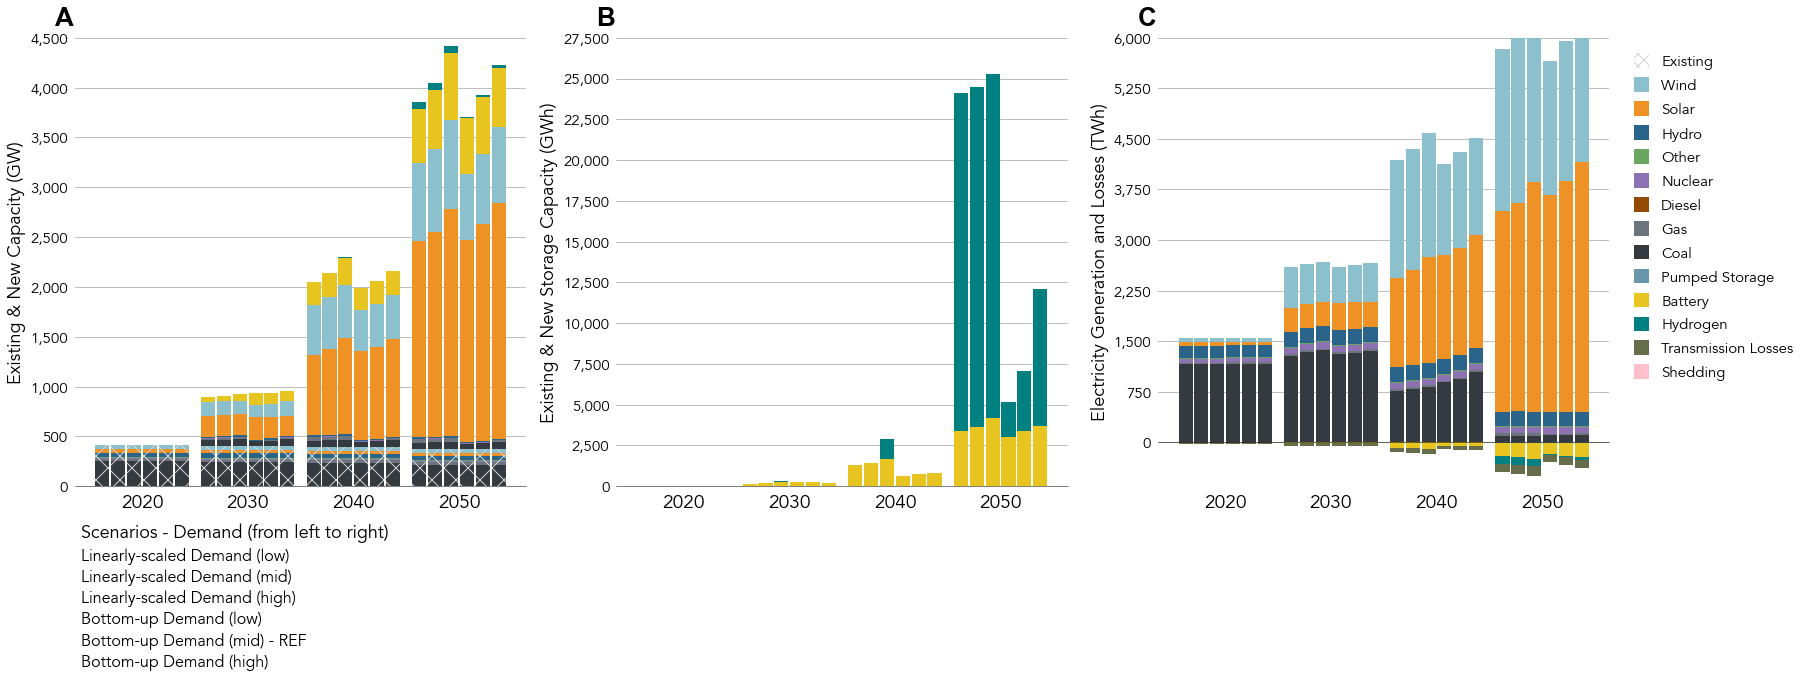

In [19]:
fig, _ax = plt.subplot_mosaic([['A', 'B', 'C']], 
                              figsize     = (27.5, 8.25), 
                              gridspec_kw = {'width_ratios': [1, 1, 1]})

for label, ax in _ax.items():
    ax.text(0.0, 1.0, label, 
            transform = (ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
            fontsize  = 26, 
            weight    = "bold",
            va        = 'bottom',
            family    = 'Arial')

_plot_new_and_existing_capacity(_ax['A'], cost_['capacity'], cost_['scen_labels'], tech_labels_,
                                ylabel       = 'Existing & New Capacity (GW)',
                                legend       = False,
                                y_lim_max    = 4500,
                                y_grid_inc   = 500)

_plot_new_and_existing_storage(_ax['B'], cost_['capacity'], cost_['scen_labels'], tech_labels_,
                               ylabel       = 'Existing & New Storage Capacity (GWh)', 
                               legend       = False,
                               y_lim_max    = 27500,
                               y_grid_inc   = 2500)

_plot_dispatch(_ax['C'], cost_['dispatch'], cost_['scen_labels'], tech_labels_, 
               ylabel       = r'Electricity Generation and Losses (TWh)', 
               legend       = True, 
               y_lim_max    = 6000,
               y_lim_min    = -650,
               y_grid_inc   = 750)

line1    = Line2D([], [], color = 'None')
handles_ = [line1, line1, line1, line1, line1, line1]
labels_  = list(cost_['scen_labels']['label'].to_numpy())

leg = _ax['A'].legend(handles_, labels_, 
                      loc            = (0., -.425),
                      title          = 'Scenarios - Technology Cost (from left to right)',
                      frameon        = False,
                      labelspacing   = 0.25,
                      title_fontsize = 18,
                      handletextpad  = -1.,
                      ncol           = 1,
                      prop           = {'size': 16})

leg._legend_box.align = "left"

plt.savefig(path_to_images + '/cost-capacity_generation.pdf', 
            bbox_inches = 'tight', 
            dpi         = 600)

plt.savefig(path_to_images + '/cost-capacity_generation.png', 
            bbox_inches = 'tight', 
            dpi         = 300)

plt.show()

# Supporting Figues

In [7]:
prodcost_                = {}
prodcost_['scen_labels'] = pd.read_csv(path_to_csvs + '/demand-scenario_labels.csv') 
prodcost_['dispatch']    = _group_dispatch_technologies(_load_dispatch(prodcost_['scen_labels']), tech_labels_)
prodcost_['capacity']    = _group_capacity_technologies(_load_capacity(prodcost_['scen_labels']), tech_labels_)

VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_90CAP_500GW_ICEDlow all /Users/Guille/Desktop/india_power/scenarios/demand


KeyboardInterrupt: 

In [ ]:
fig, _ax = plt.subplot_mosaic([['A', 'B', 'C']], 
                              layout      = 'constrained', 
                              figsize     = (20, 8.75), 
                              gridspec_kw = {'width_ratios': [1, 1, 1]})

for label, ax in _ax.items():
    ax.text(0.0, 1.0, label, 
            transform = (ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
            fontsize  = 26, 
            weight    = "bold",
            va        = 'bottom',
            family    = 'Arial')
     
y_period_loc = -.6
div_line_len = 0.61
    
_plot_new_and_existing_capacity(_ax['A'], prodcost_['capacity'], prodcost_['scen_labels'], tech_labels_,
                                ylabel       = 'Existing & New Capacity (GW)',
                                legend       = False,
                                y_lim_max    = 5000,
                                y_period_loc = y_period_loc,
                                y_grid_inc   = 500,
                                div_line_len = div_line_len)
    

_plot_new_and_existing_storage(_ax['B'], prodcost_['capacity'], prodcost_['scen_labels'], tech_labels_,
                               ylabel       = 'Existing & New Storage Capacity (GWh)', 
                               legend       = False,
                               y_lim_max    = 40000,
                               y_period_loc = y_period_loc,
                               y_grid_inc   = 4000,
                               div_line_len = div_line_len)

_plot_dispatch(_ax['C'], prodcost_['dispatch'], prodcost_['scen_labels'], tech_labels_, 
               ylabel       = r'Electricity Generation and Losses (TWh)', 
               legend       = True, 
               y_lim_max    = 6750,
               y_lim_min    = -1000,
               y_period_loc = y_period_loc*1.218,
               y_grid_inc   = 750,
               div_line_len = div_line_len)

line1    = Line2D([], [], color = 'None')
handles_ = [line1, line1, line1, line1, line1, line1]
labels_  = list(cost_['scen_labels']['label'].to_numpy())

leg = _ax['A'].legend(handles_, labels_, 
                      loc            = (0., -.425),
                      title          = 'Scenarios - Technology costs (from left to right)',
                      frameon        = False,
                      labelspacing   = 0.25,
                      title_fontsize = 18,
                      handletextpad  = -1.,
                      ncol           = 1,
                      prop           = {'size': 16})

leg._legend_box.align = "left"

plt.savefig(path_to_images + '/prodcost-capacity_generation.pdf', 
            bbox_inches = 'tight', 
            dpi         = 600)

plt.savefig(path_to_images + '/prodcost-capacity_generation.png', 
            bbox_inches = 'tight', 
            dpi         = 300)

plt.show()

In [8]:
demand_                = {}
demand_['scen_labels'] = pd.read_csv(path_to_csvs + '/demand-scenario_labels.csv') 

demand_['dispatch'] = _group_dispatch_technologies(_load_dispatch(demand_['scen_labels']), tech_labels_)
demand_['capacity'] = _group_capacity_technologies(_load_capacity(demand_['scen_labels']), tech_labels_)

VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_90CAP_500GW_ICEDlow all /Users/Guille/Desktop/india_power/scenarios/demand
VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_90CAP_500GW_ICEDmid all /Users/Guille/Desktop/india_power/scenarios/demand
VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_90CAP_500GW_ICEDhigh all /Users/Guille/Desktop/india_power/scenarios/demand
VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_90CAP_500GW_PIERlow all /Users/Guille/Desktop/india_power/scenarios/demand
VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_90CAP_500GW_PIERmid all /Users/Guille/Desktop/india_power/scenarios/cost
VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_90CAP_500GW_PIERhigh all /Users/Guille/Desktop/india_power/scenarios/demand
VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_90CAP_500GW_ICEDlow /Users/Guille/Desktop/india_power/scenarios/demand
VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_90CAP_500GW_ICEDmid /Users/Guille/Desktop/india_power/scenarios/demand
VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_90CAP_500GW_ICEDhigh /Users/Gu

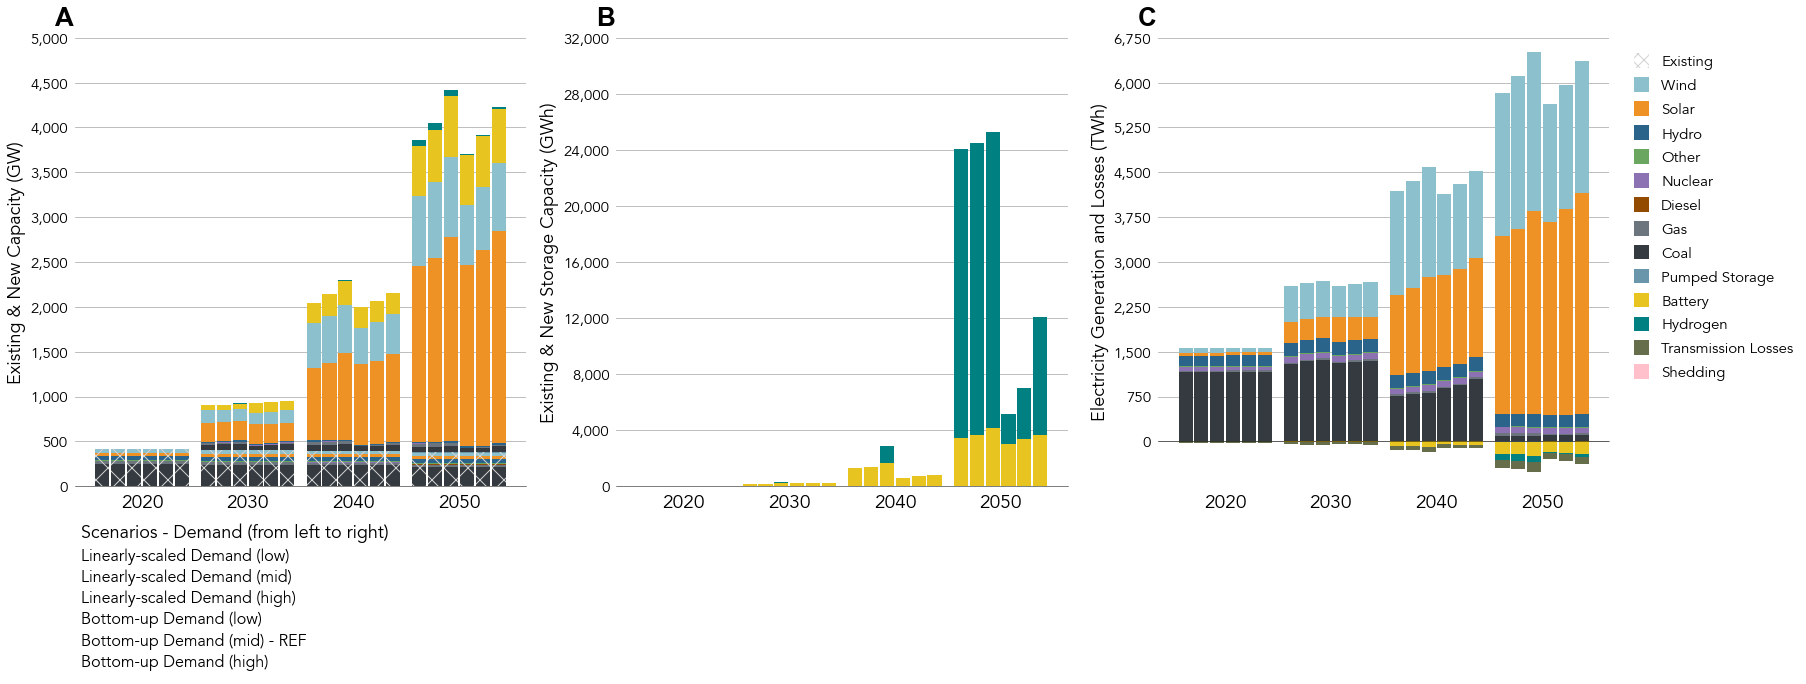

In [9]:
fig, _ax = plt.subplot_mosaic([['A', 'B', 'C']], 
                              figsize     = (27.5, 8.25), 
                              gridspec_kw = {'width_ratios': [1, 1, 1]})

for label, ax in _ax.items():
    ax.text(0.0, 1.0, label, 
            transform = (ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
            fontsize  = 26, 
            weight    = "bold",
            va        = 'bottom',
            family    = 'Arial')
     
y_period_loc = -.6
div_line_len = 0.61
    
_plot_new_and_existing_capacity(_ax['A'], demand_['capacity'], demand_['scen_labels'], tech_labels_,
                                ylabel       = 'Existing & New Capacity (GW)',
                                legend       = False,
                                y_lim_max    = 5000,
                                y_period_loc = y_period_loc,
                                y_grid_inc   = 500,
                                div_line_len = div_line_len)
    

_plot_new_and_existing_storage(_ax['B'], demand_['capacity'], demand_['scen_labels'], tech_labels_,
                               ylabel       = 'Existing & New Storage Capacity (GWh)', 
                               legend       = False,
                               y_lim_max    = 30000,
                               y_grid_inc   = 4000)

_plot_dispatch(_ax['C'], demand_['dispatch'], demand_['scen_labels'], tech_labels_, 
               ylabel       = r'Electricity Generation and Losses (TWh)', 
               legend       = True, 
               y_lim_max    = 6750,
               y_lim_min    = -750,
               y_grid_inc   = 750)

line1    = Line2D([], [], color = 'None')
handles_ = [line1, line1, line1, line1, line1, line1]
labels_  = list(demand_['scen_labels']['label'].to_numpy())

leg = _ax['A'].legend(handles_, labels_, 
                      loc            = (0., -.425),
                      title          = 'Scenarios - Demand (from left to right)',
                      frameon        = False,
                      labelspacing   = 0.25,
                      title_fontsize = 18,
                      handletextpad  = -1.,
                      ncol           = 1,
                      prop           = {'size': 16})

leg._legend_box.align = "left"

plt.savefig(path_to_images + '/demand-capacity_generation.pdf', 
            bbox_inches = 'tight', 
            dpi         = 600)

plt.savefig(path_to_images + '/demand-capacity_generation.png', 
            bbox_inches = 'tight', 
            dpi         = 300)

plt.show()

In [30]:
pier_                = {}
pier_['scen_labels'] = pd.read_csv(path_to_csvs + '/pier-scenario_labels.csv') 

pier_['dispatch'] = _group_dispatch_technologies(_load_dispatch(pier_['scen_labels']), tech_labels_)
pier_['capacity'] = _group_capacity_technologies(_load_capacity(pier_['scen_labels']), tech_labels_)

VREmid_STmid_CONVmid_H2_RES_8PRM_CC_PIERmid all /Users/Guille/Desktop/india_power/scenarios/pier
VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_PIERmid all /Users/Guille/Desktop/india_power/scenarios/pier
VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_500GW_PIERmid all /Users/Guille/Desktop/india_power/scenarios/pier
VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_80CAP_500GW_PIERmid all /Users/Guille/Desktop/india_power/scenarios/pier
VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_90CAP_500GW_PIERmid all /Users/Guille/Desktop/india_power/scenarios/cost
VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_100CAP_500GW_PIERmid all /Users/Guille/Desktop/india_power/scenarios/pier
VREmid_STmid_CONVmid_H2_RES_8PRM_CC_PIERmid /Users/Guille/Desktop/india_power/scenarios/pier
VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_PIERmid /Users/Guille/Desktop/india_power/scenarios/pier
VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/pier
VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_80CAP_

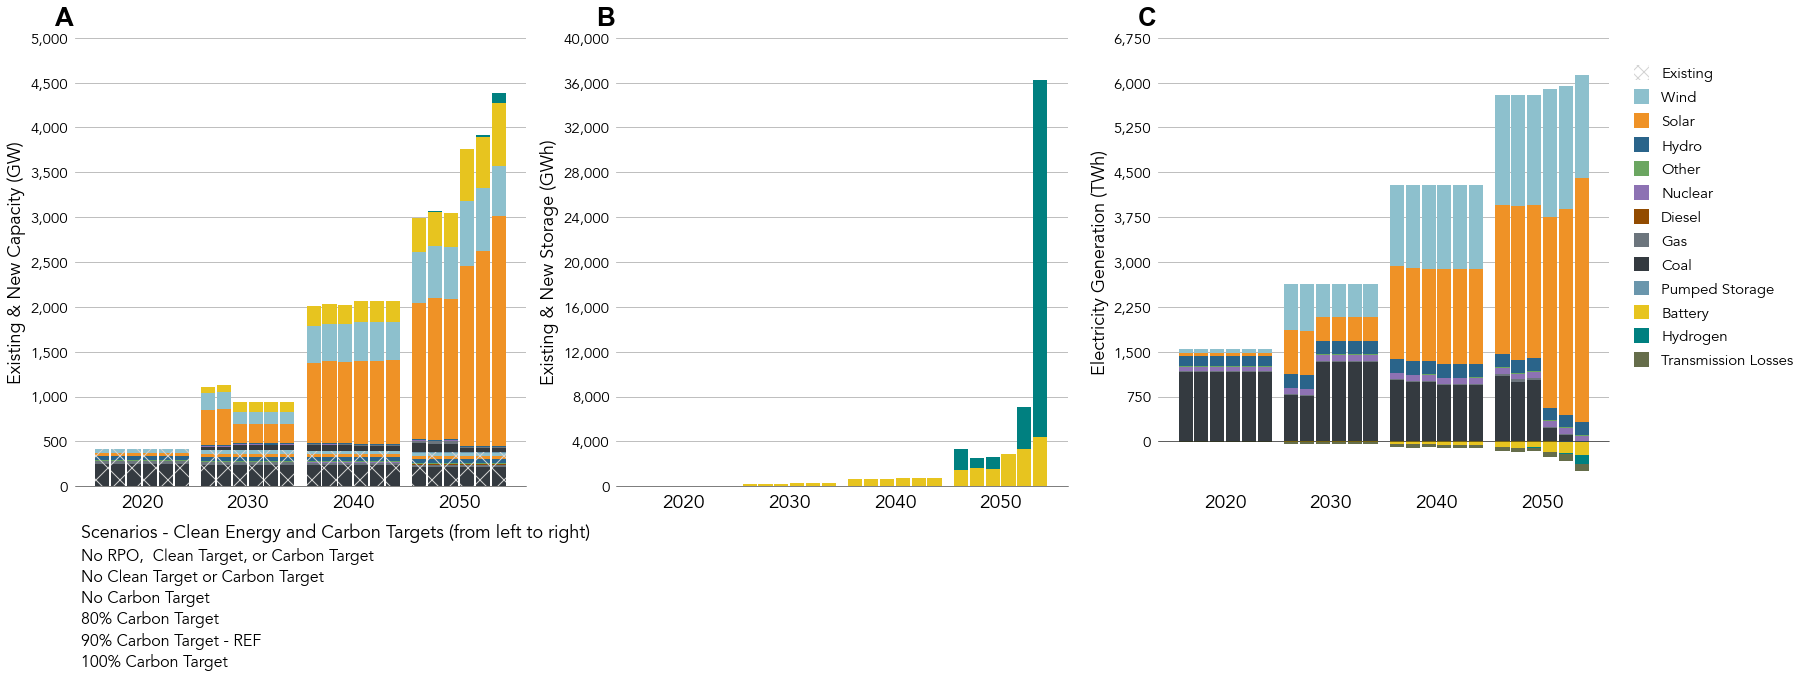

In [55]:
fig, _ax = plt.subplot_mosaic([['A', 'B', 'C']], 
                              figsize     = (27.5, 8.25), 
                              gridspec_kw = {'width_ratios': [1, 1, 1]})

for label, ax in _ax.items():
    ax.text(0.0, 1.0, label, 
            transform = (ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
            fontsize  = 26, 
            weight    = "bold",
            va        = 'bottom',
            family    = 'Arial')
    
y_period_loc = -.6
div_line_len = 0.61

_plot_new_and_existing_capacity(_ax['A'], pier_['capacity'], pier_['scen_labels'], tech_labels_,
                                ylabel       = 'Existing & New Capacity (GW)',
                                legend       = False,
                                y_lim_max    = 5000,
                                y_grid_inc   = 500)

_plot_new_and_existing_storage(_ax['B'], pier_['capacity'], pier_['scen_labels'], tech_labels_,
                               ylabel       = 'Existing & New Storage (GWh)', 
                               legend       = False,
                               y_lim_max    = 40000,
                               y_grid_inc   = 4000)

_plot_dispatch(_ax['C'], pier_['dispatch'], pier_['scen_labels'], tech_labels_, 
               ylabel       = r'Electricity Generation (TWh)', 
               legend       = True, 
               y_lim_max    = 6750,
               y_lim_min    = -750,
               y_grid_inc   = 750)

line1    = Line2D([], [], color = 'None')
handles_ = [line1, line1, line1, line1, line1, line1]
labels_  = list(pier_['scen_labels']['label'].to_numpy())

leg = _ax['A'].legend(handles_, labels_, 
                      loc            = (0., -.425),
                      title          = 'Scenarios - Clean Energy and Carbon Targets (from left to right)',
                      frameon        = False,
                      labelspacing   = 0.25,
                      title_fontsize = 18,
                      handletextpad  = -1.,
                      ncol           = 1,
                      prop           = {'size': 16})

leg._legend_box.align = "left"

plt.savefig(path_to_images + '/pier-capacity_generation.pdf', 
            bbox_inches = 'tight', 
            dpi         = 600)

plt.savefig(path_to_images + '/pier-capacity_generation.png', 
            bbox_inches = 'tight', 
            dpi         = 300)

plt.show()

In [34]:
iced_                = {}
iced_['scen_labels'] = pd.read_csv(path_to_csvs + '/iced-scenario_labels.csv') 

iced_['dispatch'] = _group_dispatch_technologies(_load_dispatch(iced_['scen_labels']), tech_labels_)
iced_['capacity'] = _group_capacity_technologies(_load_capacity(iced_['scen_labels']), tech_labels_)

VREmid_STmid_CONVmid_H2_RES_8PRM_CC_ICEDmid all /Users/Guille/Desktop/india_power/scenarios/iced
VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_ICEDmid all /Users/Guille/Desktop/india_power/scenarios/iced
VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_500GW_ICEDmid all /Users/Guille/Desktop/india_power/scenarios/iced
VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_80CAP_500GW_ICEDmid all /Users/Guille/Desktop/india_power/scenarios/iced
VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_90CAP_500GW_ICEDmid all /Users/Guille/Desktop/india_power/scenarios/demand
VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_100CAP_500GW_ICEDmid all /Users/Guille/Desktop/india_power/scenarios/iced
VREmid_STmid_CONVmid_H2_RES_8PRM_CC_ICEDmid /Users/Guille/Desktop/india_power/scenarios/iced
VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_ICEDmid /Users/Guille/Desktop/india_power/scenarios/iced
VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_500GW_ICEDmid /Users/Guille/Desktop/india_power/scenarios/iced
VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_80CA

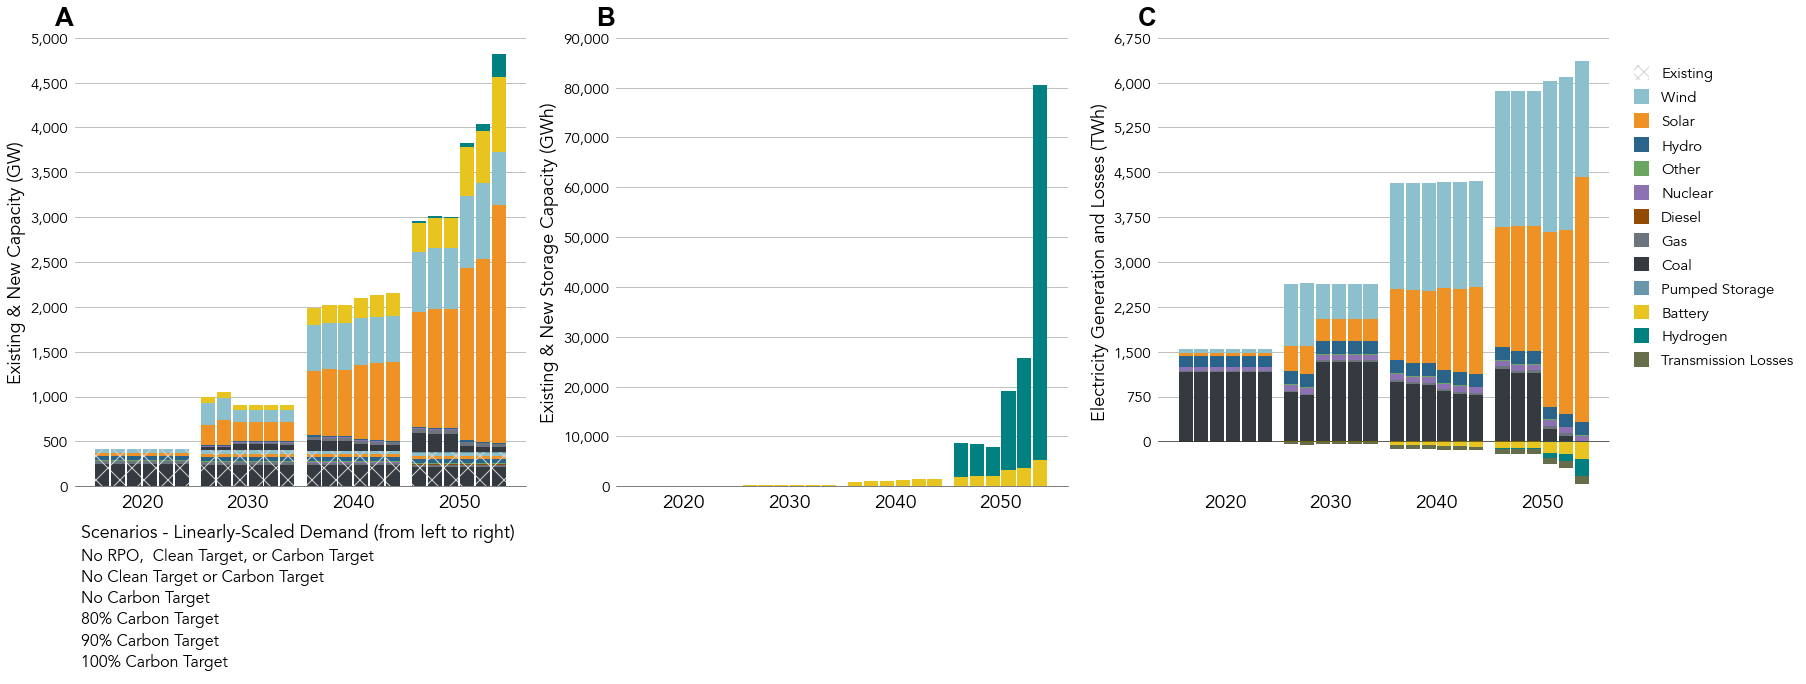

In [58]:
fig, _ax = plt.subplot_mosaic([['A', 'B', 'C']], 
                              figsize     = (27.5, 8.25), 
                              gridspec_kw = {'width_ratios': [1, 1, 1]})


for label, ax in _ax.items():
    ax.text(0.0, 1.0, label, 
            transform = (ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
            fontsize  = 26, 
            weight    = "bold",
            va        = 'bottom',
            family    = 'Arial')

y_period_loc = -.6
div_line_len = 0.61

_plot_new_and_existing_capacity(_ax['A'], iced_['capacity'], iced_['scen_labels'], tech_labels_,
                                ylabel       = 'Existing & New Capacity (GW)',
                                y_lim_max    = 5000,
                                legend       = False,
                                y_period_loc = y_period_loc,
                                y_grid_inc   = 500,
                                div_line_len = div_line_len)

_plot_new_and_existing_storage(_ax['B'], iced_['capacity'], iced_['scen_labels'], tech_labels_,
                               ylabel       = 'Existing & New Storage Capacity (GWh)', 
                               legend       = False,
                               y_lim_max    = 90000,
                               y_period_loc = y_period_loc,
                               y_grid_inc   = 10000,
                               div_line_len = div_line_len)

_plot_dispatch(_ax['C'], iced_['dispatch'], iced_['scen_labels'], tech_labels_, 
               ylabel       = r'Electricity Generation and Losses (TWh)', 
               legend       = True, 
               y_lim_max    = 6750,
               y_lim_min    = -750,
               y_period_loc = y_period_loc,
               y_grid_inc   = 750,
               div_line_len = div_line_len)

line1    = Line2D([], [], color = 'None')
handles_ = [line1, line1, line1, line1, line1, line1]
labels_  = list(iced_['scen_labels']['label'].to_numpy())

leg = _ax['A'].legend(handles_, labels_, 
                      loc            = (0., -.425),
                      title          = 'Scenarios - Linearly-Scaled Demand (from left to right)',
                      frameon        = False,
                      labelspacing   = 0.25,
                      title_fontsize = 18,
                      handletextpad  = -1.,
                      ncol           = 1,
                      prop           = {'size': 16})

leg._legend_box.align = "left"

plt.savefig(path_to_images + '/iced-capacity_generation.pdf', 
            bbox_inches = 'tight', 
            dpi         = 600)

plt.savefig(path_to_images + '/iced-capacity_generation.png', 
            bbox_inches = 'tight', 
            dpi         = 300)

plt.show()

In [36]:
alternative_                = {}
alternative_['scen_labels'] = pd.read_csv(path_to_csvs + '/alternative-scenario_labels.csv') 

alternative_['dispatch'] = _group_dispatch_technologies(_load_dispatch(alternative_['scen_labels']), tech_labels_)
alternative_['capacity'] = _group_capacity_technologies(_load_capacity(alternative_['scen_labels']), tech_labels_)

VREmid_STmid_CONVmid_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid all /Users/Guille/Desktop/india_power/scenarios/alternative


FileNotFoundError: [Errno 2] No such file or directory: '/Users/Guille/Desktop/india_power/scenarios/alternative/VREmid_STmid_CONVmid_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid/results/project_timepoint.csv'

In [ ]:
fig, _ax = plt.subplot_mosaic([['A', 'B', 'C']], 
                              layout      = 'constrained', 
                              figsize     = (20, 8.75), 
                              gridspec_kw = {'width_ratios': [1, 1, 1]})

for label, ax in _ax.items():
    ax.text(0.0, 1.0, label, 
            transform = (ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
            fontsize  = 26, 
            weight    = "bold",
            va        = 'bottom',
            family    = 'Arial')

y_period_loc = -.6
div_line_len = 0.61

_plot_new_and_existing_capacity(_ax['A'], alternative_['capacity'], alternative_['scen_labels'], tech_labels_,
                                ylabel       = 'Existing & New Capacity (GW)',
                                legend       = False,
                                y_lim_max    = 5000,
                                y_period_loc = y_period_loc,
                                y_grid_inc   = 500,
                                div_line_len = div_line_len)

_plot_new_and_existing_storage(_ax['B'], alternative_['capacity'], alternative_['scen_labels'], tech_labels_,
                               ylabel       = 'Existing & New Storage Capacity (GWh)', 
                               legend       = False,
                               y_lim_max    = 10000,
                               y_period_loc = y_period_loc,
                               y_grid_inc   = 1000,
                               div_line_len = div_line_len)

_plot_dispatch(_ax['C'], alternative_['dispatch'], alternative_['scen_labels'], tech_labels_, 
               ylabel       = r'Electricity Generation and Losses (TWh)', 
               legend       = True, 
               y_lim_max    = 7000,
               y_lim_min    = 1000,
               y_period_loc = y_period_loc,
               y_grid_inc   = 750,
               div_line_len = div_line_len)

line1    = Line2D([], [], color = 'None')
handles_ = [line1, line1, line1, line1, line1, line1]
labels_  = list(cost_['scen_labels']['label'].to_numpy())

leg = _ax['A'].legend(handles_, labels_, 
                      loc            = (0., -.425),
                      title          = 'Scenarios - Technology costs (from left to right)',
                      frameon        = False,
                      labelspacing   = 0.25,
                      title_fontsize = 18,
                      handletextpad  = -1.,
                      ncol           = 1,
                      prop           = {'size': 16})

leg._legend_box.align = "left"

plt.savefig(path_to_images + '/alternative-capacity_generation.pdf', 
            bbox_inches = 'tight', 
            dpi         = 600)

plt.savefig(path_to_images + '/alternative-capacity_generation.png', 
            bbox_inches = 'tight', 
            dpi         = 300)

plt.show()

# Electricity Generation

In [ ]:
dispatch_         = _load_dispatch(scen_labels_)
grouped_dispatch_ = _group_dispatch_technologies(dispatch_, tech_labels_)

fig = plt.figure(figsize = (12.5, 7.5))
_ax = plt.subplot(111)
    
# Enter a title of your choice between the quotation marks ('') under title = ''.
_plot_dispatch(_ax, grouped_dispatch_, scen_labels_, tech_labels_, 
               ylabel  = r'Electricity Generation (TWh)')

plt.savefig(path_to_images + r'/group_electricity_generation.png', bbox_inches = 'tight',
                                                                   dpi         = 600)

plt.show()

# New and Existing

In [ ]:
capacity_         = _load_capacity(scen_labels_)
grouped_capacity_ = _group_capacity_technologies(capacity_, tech_labels_)

### Power Capacity

In [ ]:
fig = plt.figure(figsize = (12.5, 10))
_ax = plt.subplot(111)

_plot_new_and_existing_capacity(_ax, grouped_capacity_, scen_labels_, tech_labels_,
                                ylabel = 'Existing & New Capacity (GW)')

plt.savefig(path_to_images + r'/group_installed_mw.png', 
            bbox_inches = 'tight', 
            dpi         = 600)

plt.show()

### Energy Capacity

In [ ]:
fig = plt.figure(figsize = (12.5, 10))
_ax = plt.subplot(111)

_plot_new_and_existing_storage(_ax, grouped_capacity_, scen_labels_, tech_labels_,
                               ylabel = 'Existing & New Storage (GWh)')

plt.savefig(path_to_images + r'/group_installed_mwh.png', bbox_inches = 'tight', 
                                                          dpi         = 600)
plt.show()

# Retirements

In [12]:
retirements_         = _load_capacity_retirements(cost_)
grouped_retirements_ = _group_capacity_technologies(retirements_, tech_labels_)
grouped_retirements_ = _group_by_zone(grouped_retirements_, scen_labels_)

KeyError: 'scenario'

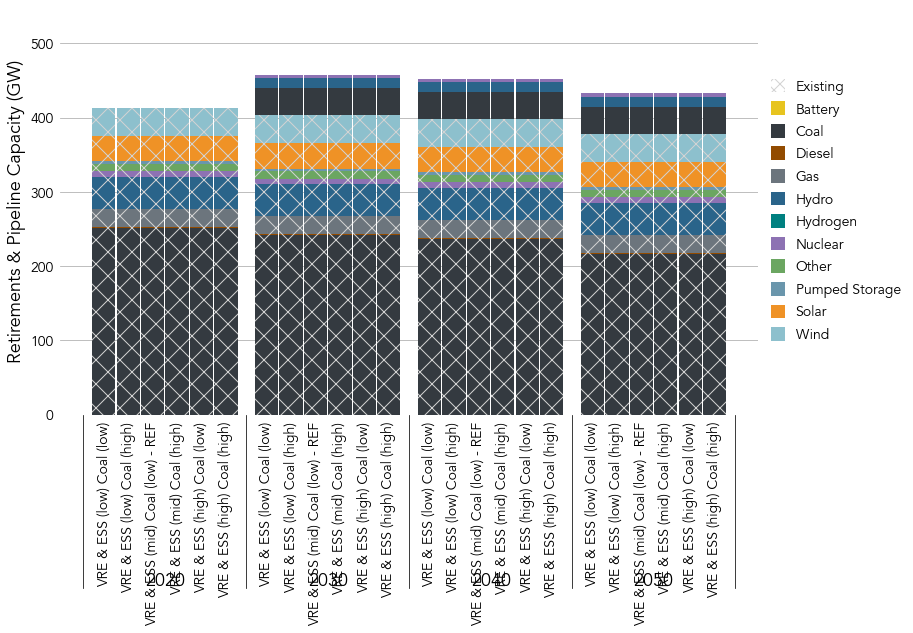

In [19]:
fig = plt.figure(figsize = (12.5, 7.5))
_ax = plt.subplot(111)

_plot_retirements_and_pipeline_capacity(_ax, grouped_retirements_, cost_['scen_labels'], tech_labels_,
                                        ylabel = 'Retirements & Pipeline Capacity (GW)') 

plt.savefig(path_to_images + r'/group_retirements_mw.png', bbox_inches = 'tight', 
                                                           dpi         = 300)
plt.show()

# New Build Capacity

In [112]:
new_build_         = _load_new_build_capacity(scen_labels_)
grouped_new_build_ = _group_capacity_technologies(new_build_, tech_labels_)
grouped_new_build_ = _group_by_zone(grouped_new_build_, scen_labels_)

VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_ICEDmid /Users/Guille/Desktop/india_power/scenarios/policy
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_500GW_ICEDmid /Users/Guille/Desktop/india_power/scenarios/policy
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_80CAP_500GW_ICEDmid /Users/Guille/Desktop/india_power/scenarios/policy
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_ICEDmid /Users/Guille/Desktop/india_power/scenarios/policy
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_100CAP_500GW_ICEDmid /Users/Guille/Desktop/india_power/scenarios/policy


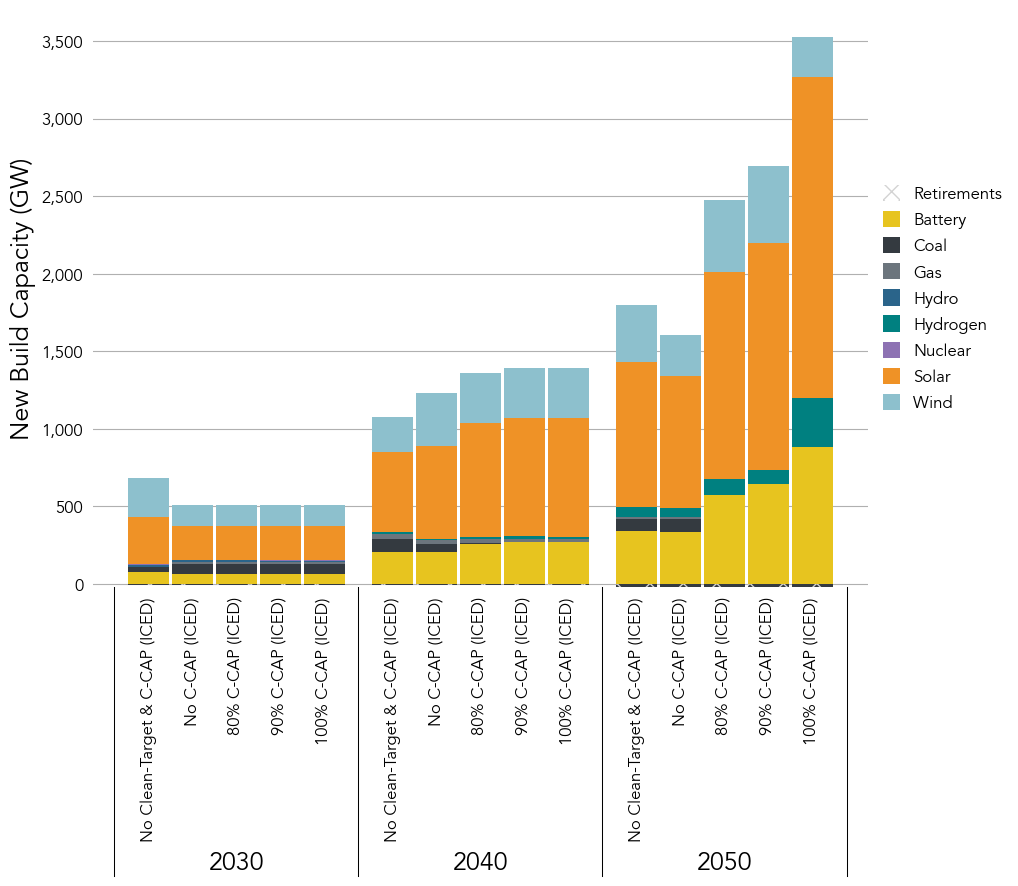

In [113]:
fig = plt.figure(figsize = (10, 7.5))
_ax = plt.subplot(111)

_plot_new_build_capacity(_ax, grouped_new_build_, scen_labels_, tech_labels_,
                         ylabel = 'New Build Capacity (GW)') 

plt.savefig(path_to_images + r'/group_new_build_mw.png', bbox_inches = 'tight', 
                                                         dpi         = 300)
plt.show()